# Background subtraction notebook

By: Megan Grout (groutm@ohsu.edu)

Adapted from code written by Dr. Marilyne Labrie and Nick Kendsersky


Last updated: 20191213

In [1]:
import os
import random
import re
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import subprocess


from scipy import signal

import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
init_notebook_mode(connected = True)

In [2]:
from cycif_modules import *

## Functions

In [3]:
# This may change for each experiment, so I have not sequestered
# this code in the my_modules.py file

# This function takes in a dataframe, changes the names
# of the column in various ways, and returns the dataframe.
# For best accuracy and generalizability, the code uses
# regular expressions (regex) to find strings for replacement.
def apply_header_changes(df):
    # remove lowercase x at beginning of name
    df.columns = df.columns.str.replace("^x","")
    # remove space at beginning of name
    df.columns = df.columns.str.replace("^ ","")
    # replace space with underscore
    df.columns = df.columns.str.replace(" ","_")
    # fix typos
    df.columns = df.columns.str.replace("CKD1","CDK1")
    df.columns = df.columns.str.replace("GAG3","GATA3")
    return df

## Begin Workflow

### Get directories

In [4]:
#set directory
## needs to be user iput

# Base directory for project
base_dir = '/Users/groutm/Desktop/weewin'
base_dir = '/Users/groutm/Desktop/reproducibility'
base_dir = 'Z:\Marilyne\Axioscan\Gao_Zhang\Segmentation'
base_dir = '/Users/groutm/Desktop/gz_new'

project_name = 'ww'
project_name = 'repro'
project_name = 'gz_new'


step_suffix = 'bs'
previous_step_suffix_long = "_qc_eda"

# Initial input data directory
#input_data_dir = r'/Users/groutm/Desktop/TMAdata'
#input_data_dir = r'/Users/groutm/Desktop/ww_data'
input_data_dir = os.path.join(base_dir, project_name + previous_step_suffix_long)


# BS directory
#output_data_dir = r'/Users/groutm/Desktop/TMAoutputdata'
#output_data_dir = r'/Users/groutm/Desktop/ww_outputdata'
output_data_dir = os.path.join(base_dir, project_name + "_" + step_suffix)

# BS images subdirectory
#output_images_dir = r'/Users/groutm/Desktop/TMAimages'
#output_images_dir = r'/Users/groutm/Desktop/wwimages'
output_images_dir = os.path.join(output_data_dir,"images")

# Metadata directories
metadata_dir = os.path.join(base_dir, project_name + "_metadata")
metadata_images_dir = os.path.join(metadata_dir,"images")

for d in [base_dir, input_data_dir, output_data_dir, output_images_dir, 
          metadata_dir, metadata_images_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

os.chdir(input_data_dir)



In [5]:
## Comment for final workflow

ls_samples = ['TMA','ww1', 'ww10', 'ww11', 'ww12', 'ww13', 'ww15', 
              'ww16', 'ww17', 'ww19', 'ww2', 'ww20', 'ww21', 
              'ww22', 'ww23', 'ww3', 'ww4', 'ww5', 'ww6', 'ww7', 
              'ww8', 'ww9']#,'bad_header_file']

ls_samples = ['TMA1.1', 'TMA1.2', 'TMA1.3', 'TMA2.1', 'TMA2.2', 'TMA2.3']

ls_samples = ['GZ10.1', 'GZ10.2', 'GZ10.3', 'TMA',
 'GZ7.1', 'GZ6', 'GZ7.2']

ls_samples = ['A_GZ2', 'B_GZ1', 'C_GZ5', 'D_GZ4', 'E_GZ3','F_GZ6','G_GZ7', 'H_GZ9','I_GZ10','TMA']

## Import all metadata we need from the QC/EDA chapter

### metadata

In [6]:
filename = "marker_intensity_metadata.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [7]:
# Open, read in information
metadata = pd.read_csv(filename)

# Verify size
#verify_line_no(filename, metadata.shape[0] + 1)


# Verify headers
exp_cols = ['Round','Target','Channel','target_lower','full_column','marker','location']
compare_headers(exp_cols, metadata.columns.values, "Marker metadata file")

['Exp']


In [8]:
# Show some of dataframe - FYI
metadata.head()

,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


### not_intensities

In [9]:
filename = "not_intensities.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [10]:
# Open, read in information
not_intensities = []
with open(filename, 'r') as fh:
    not_intensities = fh.read().strip().split("\n")
    # take str, strip whitespace, split on new line character

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, len(not_intensities))

# Print to console
print("not_intensities = ")
print(not_intensities)

Verifying data read from file is the correct length...

not_intensities = 
['Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv', 'Nucleus_Roundness', 'Nucleus_Size', 'Cell_Size', 'ROI_index', 'Sample_ID', 'replicate_ID', 'Cell_ID', 'cell_type', 'cluster', 'ID']


### full_to_short_column names

In [11]:
filename = "full_to_short_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [12]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
full_to_short_names = df.set_index('full_name').T.to_dict('records')[0]

# Print information
print('full_to_short_names =')
print(full_to_short_names)

Verifying data read from file is the correct length...

full_to_short_names =
{'53BP1_Cell_Intensity_Average': '53BP1', 'AF488_Cell_Intensity_Average': 'AF488', 'AF555_Cell_Intensity_Average': 'AF555', 'AF647_Cell_Intensity_Average': 'AF647', 'AF750_Cell_Intensity_Average': 'AF750', 'AXL_Cell_Intensity_Average': 'AXL', 'CCNA2_Cell_Intensity_Average': 'CCNA2', 'CCND1_Cell_Intensity_Average': 'CCND1', 'CD45_Cell_Intensity_Average': 'CD45', 'CD4_Cell_Intensity_Average': 'CD4', 'CD68_Cell_Intensity_Average': 'CD68', 'CD8_Cell_Intensity_Average': 'CD8', 'EGFR_Cell_Intensity_Average': 'EGFR', 'Ecad_Cell_Intensity_Average': 'Ecad', 'FOXP3_Cell_Intensity_Average': 'FOXP3', 'H3K27me3_Cell_Intensity_Average': 'H3K27me3', 'KI67_Cell_Intensity_Average': 'KI67', 'MITF_Cell_Intensity_Average': 'MITF', 'PCNA_Cell_Intensity_Average': 'PCNA', 'PDGFR_Cell_Intensity_Average': 'PDGFR', 'S100_Cell_Intensity_Average': 'S100', 'Vimentin_Cell_Intensity_Average': 'Vimentin', 'p4EBP1_Cell_Intensity_Average': 'p

### short_to_full_column_names

In [13]:
filename = "short_to_full_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [14]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
short_to_full_names = df.set_index('short_name').T.to_dict('records')[0]

# Print information
print('short_to_full_names =')
print(short_to_full_names)

Verifying data read from file is the correct length...

short_to_full_names =
{'53BP1': '53BP1_Cell_Intensity_Average', 'AF488': 'AF488_Cell_Intensity_Average', 'AF555': 'AF555_Cell_Intensity_Average', 'AF647': 'AF647_Cell_Intensity_Average', 'AF750': 'AF750_Cell_Intensity_Average', 'AXL': 'AXL_Cell_Intensity_Average', 'CCNA2': 'CCNA2_Cell_Intensity_Average', 'CCND1': 'CCND1_Cell_Intensity_Average', 'CD45': 'CD45_Cell_Intensity_Average', 'CD4': 'CD4_Cell_Intensity_Average', 'CD68': 'CD68_Cell_Intensity_Average', 'CD8': 'CD8_Cell_Intensity_Average', 'EGFR': 'EGFR_Cell_Intensity_Average', 'Ecad': 'Ecad_Cell_Intensity_Average', 'FOXP3': 'FOXP3_Cell_Intensity_Average', 'H3K27me3': 'H3K27me3_Cell_Intensity_Average', 'KI67': 'KI67_Cell_Intensity_Average', 'MITF': 'MITF_Cell_Intensity_Average', 'PCNA': 'PCNA_Cell_Intensity_Average', 'PDGFR': 'PDGFR_Cell_Intensity_Average', 'S100': 'S100_Cell_Intensity_Average', 'Vimentin': 'Vimentin_Cell_Intensity_Average', 'p4EBP1': 'p4EBP1_Cell_Intensity_Av

### Color information

#### Samples

In [15]:
filename = "sample_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [16]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
sample_color_dict = df.set_index('Sample_ID').T.to_dict('rgb')[0]

# Print information
print('sample_color_dict =')
print(sample_color_dict)


Verifying data read from file is the correct length...

sample_color_dict =
{'A_GZ2': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'B_GZ1': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'C_GZ5': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'D_GZ4': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'E_GZ3': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'F_GZ6': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'G_GZ7': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'H_GZ9': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'I_GZ10': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'TMA': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)}


#### Channels

In [17]:
filename = "channel_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [18]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
channel_color_dict = df.set_index('Channel').T.to_dict('rgb')[0]

# Print information
print('channel_color_dict =')
print(channel_color_dict)


Verifying data read from file is the correct length...

channel_color_dict =
{'c3': (1.0, 0.6470588235294118, 0.0), 'c4': (1.0, 0.0, 0.0), 'c5': (0.25098039215686274, 0.8784313725490196, 0.8156862745098039), 'c2': (0.0, 0.5019607843137255, 0.0)}


#### Round

In [19]:
filename = "round_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [20]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
round_color_dict = df.set_index('Round').T.to_dict('rgb')[0]

# Print information
print('round_color_dict =')
print(round_color_dict)


Verifying data read from file is the correct length...

round_color_dict =
{'R0': (0.28685356234627135, 0.13009829239513535, 0.23110332132624437), 'R1': (0.3736023974468758, 0.214424058315835, 0.3978381676792029), 'R2': (0.4159341362257507, 0.3236230119238674, 0.5522993139842536), 'R3': (0.4347275623260717, 0.45841778084048856, 0.6693193307565182), 'R4': (0.45985383722977585, 0.5938507827180669, 0.7299938636762819), 'R5': (0.5193510814616777, 0.7186903518953451, 0.7537488291211205), 'R6': (0.6251959781814483, 0.8211474484187268, 0.77115296242133), 'R7': (0.7684256891219349, 0.8992667116749021, 0.8171383269422353)}


## Import data

In [21]:
# Import all data files for this portion of workflow

# First gather information on expected headers using first file in ls_samples



# Read in the first row of the file correpsonding to the first sample (index = 0)
# in ls_samples
df = pd.read_csv(ls_samples[0] + 
                 previous_step_suffix_long + ".csv", nrows = 1, index_col = 0)

# Apply the changes to the headers as specified in above funciton
df = apply_header_changes(df)

# Set variable to hold default header values
expected_headers = df.columns.values

print("df index name is currently",df.index.name)

df index name is currently None


In [22]:
df.head()

,Nucleus_Size,Nucleus_Roundness,Sample_ID,Cell_Size,ROI_index,Nuc_Y,Nuc_X_Inv,Nuc_X,Nuc_Y_Inv,53BP1_Cell_Intensity_Average,...,p4EBP1_Cell_Intensity_Average,p75_Cell_Intensity_Average,pATM_Cell_Intensity_Average,pATR_Cell_Intensity_Average,pCHK2_Cell_Intensity_Average,pEGFR_Cell_Intensity_Average,pGSK3b_Cell_Intensity_Average,pH2AX_Cell_Intensity_Average,pHH3_Cell_Intensity_Average,pS6_Cell_Intensity_Average
A_GZ2_Cell_0,103,0.619081,A_GZ2,329,1,4503.174805,10283.475586,10114.524414,14063.825195,4487.468262,...,2797.301025,922.088135,3000.461914,3341.857178,3237.069824,1425.282715,2911.632324,1159.088135,3308.157959,2330.209717


In [23]:
print("Used " + ls_samples[0] + previous_step_suffix_long +
      ".csv to determine the expected, corrected headers for all files.")
print("There headers are: \n" + ", ".join([h for h in expected_headers]) + ".")

Used A_GZ2_qc_eda.csv to determine the expected, corrected headers for all files.
There headers are: 
Nucleus_Size, Nucleus_Roundness, Sample_ID, Cell_Size, ROI_index, Nuc_Y, Nuc_X_Inv, Nuc_X, Nuc_Y_Inv, 53BP1_Cell_Intensity_Average, AF488_Cell_Intensity_Average, AF555_Cell_Intensity_Average, AF647_Cell_Intensity_Average, AF750_Cell_Intensity_Average, AXL_Cell_Intensity_Average, CCNA2_Cell_Intensity_Average, CCND1_Cell_Intensity_Average, CD45_Cell_Intensity_Average, CD4_Cell_Intensity_Average, CD68_Cell_Intensity_Average, CD8_Cell_Intensity_Average, EGFR_Cell_Intensity_Average, Ecad_Cell_Intensity_Average, FOXP3_Cell_Intensity_Average, H3K27me3_Cell_Intensity_Average, KI67_Cell_Intensity_Average, MITF_Cell_Intensity_Average, PCNA_Cell_Intensity_Average, PDGFR_Cell_Intensity_Average, S100_Cell_Intensity_Average, Vimentin_Cell_Intensity_Average, p4EBP1_Cell_Intensity_Average, p75_Cell_Intensity_Average, pATM_Cell_Intensity_Average, pATR_Cell_Intensity_Average, pCHK2_Cell_Intensity_Averag

In [24]:
# Import all dfs

## TO-DO: include check that imported df is the expected size and shape...

dfs = {}
for sample in ls_samples:
    # Open file
    ################################
    # only reading first 500 lines #
    ################################
    if not os.path.exists(sample+previous_step_suffix_long+".csv"):
        print("File " + sample+previous_step_suffix_long+".csv" +
             " does not exist. Removing from analysis...")
        ls_samples.remove(sample)
        continue
    
    df = pd.read_csv(sample + previous_step_suffix_long + ".csv", 
                     index_col = 0)
    
    # Check for empty df
    # if so, don't continue trying to process df
    if df.shape[0] == 0:
        print('Zero content lines detected in ' + sample + ' file.'
              'Removing from analysis...')
        ls_samples.remove(sample)
        continue
    
    # Instead of reading only the top 500 row in the file,
    # let's read in all rows and then only use a random
    # sampling (w/o replacement) of 500
    
    
    # Verify that the loaded df are the right length
    try:
        verify_line_no(sample + previous_step_suffix_long + ".csv", 
                   df.shape[0] + 1)
    except:
        pass
    # adding 1 because we expect the header was detected 
    # during file import and not counted towards length of df
    
     # Manipulations necessary for concatenation
    df = apply_header_changes(df)
    df = df[[x for x in sorted(df.columns.values)]]
    
    # Compare headers of new df against what is expected
    compare_headers(expected_headers, df.columns.values, sample)
    df['Sample_ID'] = sample

    # For cases where we have samples called TMA1.1, TMA1.2, TMA1.3, etc.
    # Using regular expressions (regex) to extract the characters in the
    # sample name from TMA to the following digits, stopping at the period
    #if 'ROI_index' in df.columns.values:
    #    df['ROI_slide'] = re.findall(r'(TMA\d+)',sample)[0]    
    
    # Add to df of dfs 
    dfs[sample] = df
    



#Merge dfs into one df
df = pd.concat(dfs.values(), ignore_index=False , sort = False)
del dfs


Let's take a look at a few features to make sure our dataframe is as expected

In [25]:
df.shape

(1023317, 41)

In [26]:
df.index 

Index(['A_GZ2_Cell_0', 'A_GZ2_Cell_1', 'A_GZ2_Cell_2', 'A_GZ2_Cell_3',
       'A_GZ2_Cell_4', 'A_GZ2_Cell_5', 'A_GZ2_Cell_6', 'A_GZ2_Cell_7',
       'A_GZ2_Cell_8', 'A_GZ2_Cell_9',
       ...
       'TMA_Cell_143424', 'TMA_Cell_143425', 'TMA_Cell_143426',
       'TMA_Cell_143427', 'TMA_Cell_143428', 'TMA_Cell_143429',
       'TMA_Cell_143430', 'TMA_Cell_143431', 'TMA_Cell_143432',
       'TMA_Cell_143433'],
      dtype='object', length=1023317)

In [27]:
#check for NaN entries (should not be any unless columns do not align)
# if there are any null values, then print names of columns containing
# null values
if df.isnull().any().any():
    print(df.columns[df.isnull().any()])

#in 'if' statement, false means no NaN entries True means NaN entries 

In [28]:
## Remove in final workflow

if 'bad_header_file' in ls_samples:
    ls_samples.remove("bad_header_file")
if 'bad_header_file' in df.Sample_ID.unique():
    df = df.loc[df['Sample_ID'] != 'bad_header_file',:]

In [29]:
# Check that all expected files were imported into final dataframe

if sorted(df.Sample_ID.unique()) == sorted(ls_samples):
    print("All expected filenames present in big df Sample_ID column.")
else:
    compare_headers(['no samples'], df.Sample_ID.unique(), "big df Sample_ID column")

All expected filenames present in big df Sample_ID column.


QC checks...

### Filtering

#### Filter rows with 0 mean intensity

In [30]:
#df = df.rename(columns = short_to_full_names)

## R Shiny Filtering App

In [31]:
df.columns.values

array(['53BP1_Cell_Intensity_Average', 'AF488_Cell_Intensity_Average',
       'AF555_Cell_Intensity_Average', 'AF647_Cell_Intensity_Average',
       'AF750_Cell_Intensity_Average', 'AXL_Cell_Intensity_Average',
       'CCNA2_Cell_Intensity_Average', 'CCND1_Cell_Intensity_Average',
       'CD45_Cell_Intensity_Average', 'CD4_Cell_Intensity_Average',
       'CD68_Cell_Intensity_Average', 'CD8_Cell_Intensity_Average',
       'Cell_Size', 'EGFR_Cell_Intensity_Average',
       'Ecad_Cell_Intensity_Average', 'FOXP3_Cell_Intensity_Average',
       'H3K27me3_Cell_Intensity_Average', 'KI67_Cell_Intensity_Average',
       'MITF_Cell_Intensity_Average', 'Nuc_X', 'Nuc_X_Inv', 'Nuc_Y',
       'Nuc_Y_Inv', 'Nucleus_Roundness', 'Nucleus_Size',
       'PCNA_Cell_Intensity_Average', 'PDGFR_Cell_Intensity_Average',
       'ROI_index', 'S100_Cell_Intensity_Average', 'Sample_ID',
       'Vimentin_Cell_Intensity_Average', 'p4EBP1_Cell_Intensity_Average',
       'p75_Cell_Intensity_Average', 'pATM_Cell_Inten

In [32]:
#delete small cells and objects w/high AF555 Signal (RBCs)
df = df.loc[(df['Nucleus_Size'] > 60 )]
df = df.loc[(df['Nucleus_Size'] < 600 )]
print("Number of cells after filtering on nucleus size:", df.shape[0])

#df = df.loc[(df['AF555_Cytoplasm_Intensity_Average'] < 2500)]
#df = df.loc[(df['AF555_Nucleus'] < 3000)]
df = df.loc[(df['AF555_Cell_Intensity_Average'] < 2500)]
print("Number of cells after filtering on AF555 ___ intensity:", df.shape[0])

Number of cells after filtering on nucleus size: 883317
Number of cells after filtering on AF555 ___ intensity: 725055


#### Assign Cell types

Save file for filtering app.

In [33]:
subset_row_count = 10000

In [34]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_app = maintain_value_counts(df, 'Sample_ID',subset_row_count)
counts_for_app

,current_row_count,prop,desired_row_count
A_GZ2,66137,0.091217,912
B_GZ1,1443,0.001990,20
C_GZ5,185,0.000255,3
D_GZ4,47135,0.065009,650
E_GZ3,5502,0.007588,76
F_GZ6,54962,0.075804,758
G_GZ7,425692,0.587117,5871
I_GZ10,32079,0.044244,442
TMA,91920,0.126777,1268


In [35]:
# Create new df to hold our heatmap data
for_app_data = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_app.loc[counts_for_app.index == sample,'current_row_count'].values[0]
    size = counts_for_app.loc[counts_for_app.index == sample,'desired_row_count'].values[0]
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    for_app_data = for_app_data.append(df_sample.iloc[random_rows,:])
    
#for_app_data = for_app_data.loc[:,~for_app_data.columns.isin(not_intensities)]

In [36]:
filename = "for_filtering_app.csv"
filename = os.path.join(output_data_dir,filename)
for_app_data.to_csv(filename, index = False)

In [37]:
#assign tumor cells 

def assign_cell_type(row):
    print(row.keys)
    if (row['CKs_Cytoplasm_Intensity_Average'] > 2000)  \
        | (row['Ecad_Cytoplasm_Intensity_Average'] > 1800) \
        | (row['NCad_Cytoplasm_Intensity_Average'] > 2200):
            return 'TUMOR'
    elif (row['CD45_Cytoplasm_Intensity_Average'] > 4500) \
     | (row['CD4_Cytoplasm_Intensity_Average'] > 3000) \
     | (row['CD68_Cytoplasm_Intensity_Average'] > 3200):
        return 'IMMUNE'
    else:
        return 'STROMA'
    

    
# randoml assigning here just for development purposes
def assign_cell_type(row):
    n = np.random.randint(0,10)
    if n < 2:
        return 'IMMUNE'
    if n < 5:
        return 'CANCER'    
    return 'STROMA'

# First create a cell_type column and make it blank
df['cell_type'] = ''

# Then iterate through each sample and perform the cell type assignment as necessary
my_list = [] # put sample names here
my_list = ls_samples.copy() # comment this line out
for sample in my_list:
    df.loc[df['Sample_ID'] == sample,'cell_type'] = df.apply(lambda row: assign_cell_type(row), axis = 1)

For saving parameters to file:

In [38]:
# Create empty dataframe to hold parameters

my_cols = ['Sample_ID','a','b']
filtering_params = pd.DataFrame(columns = my_cols)

In [39]:
filtering_params

,Sample_ID,a,b


In [40]:
# Add your param info
filtering_params = filtering_params.append(
    pd.DataFrame(
        {'Sample_ID':['my sample'],
         'a':['parameter value'],
        'b':['parameter value']}), sort = True)

filtering_params

,Sample_ID,a,b
0,my sample,parameter value,parameter value


In [41]:
# Save to file

filename = "filtering_params.csv"
filename = os.path.join(output_data_dir, filename)
filtering_params.to_csv(filename, index = False)

Save counts of each cell type to file

In [42]:
# By Sample_ID, by cell type
cell_series = df.groupby('Sample_ID').cell_type.value_counts()
filename = "counts_by_sample_ID_by_cell_type.csv"
filename = os.path.join(output_data_dir, filename)
cell_series.to_csv(filename, header = True)
print("Cell counts by Sample_ID, by cell type:")
print(cell_series)

# Just by cell type
cell_series = df.cell_type.value_counts()
filename = "counts_by_cell_type.csv"
filename = os.path.join(output_data_dir, filename)
cell_series.to_csv(filename, header = True)
print("Cell counts by cell type:")
print(cell_series)

Cell counts by Sample_ID, by cell type:
Sample_ID  cell_type
A_GZ2      STROMA        33078
           CANCER        19727
           IMMUNE        13332
B_GZ1      STROMA          753
           CANCER          425
           IMMUNE          265
C_GZ5      STROMA           99
           IMMUNE           49
           CANCER           37
D_GZ4      STROMA        23598
           CANCER        14193
           IMMUNE         9344
E_GZ3      STROMA         2721
           CANCER         1632
           IMMUNE         1149
F_GZ6      STROMA        27811
           CANCER        16446
           IMMUNE        10705
G_GZ7      STROMA       212729
           CANCER       128013
           IMMUNE        84950
I_GZ10     STROMA        16026
           CANCER         9658
           IMMUNE         6395
TMA        STROMA        46103
           CANCER        27507
           IMMUNE        18310
Name: cell_type, dtype: int64
Cell counts by cell type:
STROMA    362918
CANCER    217638
IMMUNE    14

### Establish colors to use throughout workflow

Cell type - want colors that are categorical, since Cell Type is a non-ordered category. A categorical color palette will have dissimilar colors.

Unique cell types are: ['CANCER' 'STROMA' 'IMMUNE']


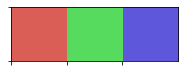

In [43]:
# Get those unique colors
cell_types = ['STROMA','CANCER','IMMUNE']
color_values = sb.color_palette("hls",n_colors = len(cell_types))#'HLS'
# each color value is a tuple of three values: (R, G, B)

print("Unique cell types are:",df.cell_type.unique())
# Display those unique colors
sb.palplot(sb.color_palette(color_values))

# allow for user-input of named colors

Store in a dictionary

In [44]:
celltype_color_dict = dict(zip(cell_types, color_values))

In [45]:
celltype_color_dict

{'STROMA': (0.86, 0.3712, 0.33999999999999997),
 'CANCER': (0.33999999999999997, 0.86, 0.3712),
 'IMMUNE': (0.3712, 0.33999999999999997, 0.86)}

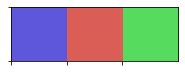

In [46]:
## Here is an example of how you might specify the values yourself,
# derived from the QC/EDA chapter

#celltype_color_dict['CANCER'] = mplc.to_rgb('xkcd:dark sky blue')
#celltype_color_dict['IMMUNE'] = mplc.to_rgb('xkcd:reddish orange')
#celltype_color_dict['STROMA'] = mplc.to_rgb('xkcd:jungle green')

sb.palplot(sb.color_palette(
    [celltype_color_dict['IMMUNE'],
     celltype_color_dict['STROMA'],
     celltype_color_dict['CANCER']]))


#### Save color information (mapping and legend) to metadata directory

In [47]:
# Create dataframe
celltype_color_df = color_dict_to_df(celltype_color_dict, "cell_type")
celltype_color_df.head()

# Save to file in metadatadirectory
filename = "celltype_color_data.csv"
filename = os.path.join(metadata_dir, filename)
celltype_color_df.to_csv(filename, index = False)

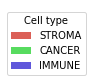

In [48]:
# Legend of cell type info only

g  = plt.figure(figsize = (1,1)).add_subplot(111)
g.axis('off')
handles = []
for item in celltype_color_dict.keys():
        h = g.bar(0,0, color = celltype_color_dict[item],
                  label = item, linewidth =0)
        handles.append(h)
first_legend = plt.legend(handles=handles, loc='upper right', title = 'Cell type'),


filename = "Celltype_legend.png"
filename = os.path.join(metadata_images_dir, filename)
plt.savefig(filename, bbox_inches = 'tight')

#### Plot the post-filtering nucleus sizes, colored by cell type

In [49]:
make_distr_plot_per_sample(title = "Post-filtering nucleus sizes",
                           dfs = [df.loc[df['cell_type'] == 'STROMA',:],
                               df.loc[df['cell_type'] == 'IMMUNE',:],
                                  df.loc[df['cell_type'] == 'CANCER',:]], 
                           df_names = ['Immune','Cancer','Stroma'], 
                           colors = [celltype_color_dict['STROMA'],
                               celltype_color_dict['IMMUNE'],
                                    celltype_color_dict['CANCER']
                                    ], 
                           x_label = "Nucleus Size", 
                           legend = False,
                           markers = ['Nucleus_Size'],
                          location = output_images_dir)

# note that the traces are layered on top of each other, so if the tallest trace is in front, 
# then the other two will be tinted accordingly. You can change around the order of the data
# in the parameter dfs = [] above, but don't forget to also change the order of the colors = []
# parameter accordingly!!

#### Bar plots

In [50]:
# Get counts for each Sample_ID, sorted by Sample_ID
sample_counts = pd.DataFrame(df.Sample_ID.value_counts()).sort_index()
sample_counts = sample_counts.rename(columns = {'Sample_ID':'counts'})
sample_counts['Sample_ID'] = sample_counts.index
#counts['color'] = counts.apply(lambda row: color_dict[row['Sample_ID']], axis = 1)
sample_counts

# There should be a better way to do this with 'groupby' or something
stroma_counts = pd.DataFrame({'stroma':
    df.loc[
        df['cell_type'] == 'STROMA',:].Sample_ID.value_counts()}).sort_index()

immune_counts = pd.DataFrame({'immune':
    df.loc[
        df['cell_type'] == 'IMMUNE',:].Sample_ID.value_counts()}).sort_index()

cancer_counts = pd.DataFrame({'cancer':
    df.loc[
        df['cell_type'] == 'CANCER',:].Sample_ID.value_counts()}).sort_index()

counts = pd.concat([sample_counts, stroma_counts,cancer_counts,immune_counts],
                   axis = 1, sort = False)
counts.head()

,counts,Sample_ID,stroma,cancer,immune
A_GZ2,66137,A_GZ2,33078,19727,13332
B_GZ1,1443,B_GZ1,753,425,265
C_GZ5,185,C_GZ5,99,37,49
D_GZ4,47135,D_GZ4,23598,14193,9344
E_GZ3,5502,E_GZ3,2721,1632,1149


In [51]:
def get_perc(row, cell_type):
    total = row['stroma'] + row['immune'] + row['cancer']
    return round(row[cell_type]/total *100,1)

counts['stroma_perc'] = counts.apply(lambda row: get_perc(row, 'stroma'), axis = 1)
counts['immune_perc'] = counts.apply(lambda row: get_perc(row, 'immune'), axis = 1)
counts['cancer_perc'] = counts.apply(lambda row: get_perc(row, 'cancer'), axis = 1)

In [52]:
# By sample ID only - move this to immediately post-filtering, so we can know if we adjusted the filtering parameters correctly.

fig = go.Figure()
title = 'Post-filtering BS Cell counts by Sample ID'

for sample in ls_samples:
    fig.add_trace(go.Bar(
        x=counts.loc[counts['Sample_ID']==sample,'Sample_ID'], 
        y = counts.loc[counts['Sample_ID']==sample,'counts'],
        text = counts.loc[counts['Sample_ID']==sample,'counts'], textposition='outside',
        marker=dict(
            color='rgb' + str(sample_color_dict[sample])),
            showlegend = False
        
    ))
fig.update_layout(title = title, plot_bgcolor = 'white')
fig.update_xaxes(title_text = "Sample ID", linecolor = 'black')
fig.update_yaxes(title_text = "Cell count", linecolor = "black")


#plot(fig)
fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")


In [53]:
# By sample ID and cell type - proportion

fig = go.Figure()
title = 'BS Cell proportions by Sample ID and tissue type'

fig = go.Figure(data=[
    go.Bar(name='Stroma', x=counts['Sample_ID'], y=counts['stroma_perc'], 
           text = counts['stroma_perc'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['STROMA'])),
    go.Bar(name='Immune', x=counts['Sample_ID'], y=counts['immune_perc'], 
           text = counts['immune_perc'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['IMMUNE'])),
    go.Bar(name='Cancer',x=counts['Sample_ID'], y=counts['cancer_perc'], 
           text = counts['cancer_perc'], textposition='auto', 
           marker_color = 'rgb' + str(celltype_color_dict['CANCER']))
])
    
fig.update_layout(title = title, plot_bgcolor = 'white',barmode ='stack')
fig.update_xaxes(title = "Sample", linecolor = 'black')
fig.update_yaxes(title = "Cell count", linecolor = 'black')
#plot(fig)
fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")


In [54]:
# By sample ID and cell type - count

fig = go.Figure()
title = 'BS Cell counts by Sample ID and tissue type'

fig = go.Figure(data=[
    go.Bar(name='Stroma', x=counts['Sample_ID'], y=counts['stroma'], 
           text = counts['stroma'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['STROMA'])),
    go.Bar(name='Immune', x=counts['Sample_ID'], y=counts['immune'], 
           text = counts['immune'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['IMMUNE'])),
    go.Bar(name='Cancer',x=counts['Sample_ID'], y=counts['cancer'], 
           text = counts['cancer'], textposition='auto', 
           marker_color = 'rgb' + str(celltype_color_dict['CANCER']))
])
    
fig.update_layout(title = title, plot_bgcolor = 'white',barmode ='stack')
fig.update_xaxes(title = "Sample", linecolor = 'black')
fig.update_yaxes(title = "Cell count", linecolor = 'black')
#plot(fig)
fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")


### Continue with BS

#### Divide each marker (and its location) by the right exposure setting for each group of samples

In [55]:
def divide_exp_time(col, exp_col):
    exp_time = metadata.loc[metadata['full_column'] == col.name, exp_col].values[0]
    
    return col/exp_time

#df.loc[df['ROI_slide'] == 'TMA1',~df.columns.isin(not_intensities)] = \
#    df.loc[df['ROI_slide'] == 'TMA1',~df.columns.isin(not_intensities)].apply(
#    lambda column: divide_exp_time(column, 'Exp_TMA1'), axis = 0)

#df.loc[df['ROI_slide'] == 'TMA2',~df.columns.isin(not_intensities)] = \
#    df.loc[df['ROI_slide'] == 'TMA2',~df.columns.isin(not_intensities)].apply(
#    lambda column: divide_exp_time(column, 'Exp_TMA2'), axis = 0)

df.loc[:, ~df.columns.isin(not_intensities)] = \
    df.loc[:, ~df.columns.isin(not_intensities)].apply(
    lambda column: divide_exp_time(column, 'Exp'), axis = 0)

#### Do background subtraction

In [56]:
metadata.head()


,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


In [57]:
metadata.to_csv("/Users/groutm/Desktop/metadata_for_PCA_test.csv", index = False)

In [58]:
# this uses a df (metadata) outside of 
# the scope of the lambda...
# careful that this might break inside of a script...

def do_background_sub(col):
    #print(col.name)
    location = metadata.loc[metadata['full_column'] == col.name, 'location'].values[0]
    #print('location = ' + location)
    channel = metadata.loc[metadata['full_column'] == col.name, 'Channel'].values[0]
    #print('channel = ' + channel)
    af_target = metadata.loc[
        (metadata['Channel']==channel) \
        & (metadata['location']==location) \
        &(metadata['target_lower'].str.contains(r'^af\d{3}$')),\
        'full_column'].values[0]
    #print('af_target = ' + af_target)
    # ^ right channel, right location, right maker (AF baseline)
    # don't want to subtract an AF channel from itself
    if af_target == col.name:
        return col
    return col - df.loc[:,af_target]



df.loc[:,~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].apply(
    lambda column: do_background_sub(column), axis = 0)

### Adjust for outliers

In [59]:
#remove outliers (replace outliers with X percentile)
outlier_percent = 0.005

upper_lim = df.loc[
    :,~df.columns.isin(not_intensities)].quantile(1 - outlier_percent)

upper_outliers = (df.loc[:,~df.columns.isin(not_intensities)] > upper_lim)

df.loc[:,~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].mask(upper_outliers, upper_lim, axis=1)  



In [60]:
# Diplay what the upper limits are for each marker
upper_lim

53BP1_Cell_Intensity_Average         6.832279
AF488_Cell_Intensity_Average        19.727998
AF555_Cell_Intensity_Average         1.656746
AF647_Cell_Intensity_Average         2.080911
AF750_Cell_Intensity_Average         2.672120
AXL_Cell_Intensity_Average           2.799535
CCNA2_Cell_Intensity_Average         1.216829
CCND1_Cell_Intensity_Average         3.208696
CD45_Cell_Intensity_Average          2.540298
CD4_Cell_Intensity_Average          10.925023
CD68_Cell_Intensity_Average          4.234022
CD8_Cell_Intensity_Average           9.717770
EGFR_Cell_Intensity_Average          3.415605
Ecad_Cell_Intensity_Average          9.989728
FOXP3_Cell_Intensity_Average         1.501865
H3K27me3_Cell_Intensity_Average     21.765149
KI67_Cell_Intensity_Average         18.431720
MITF_Cell_Intensity_Average          8.859274
PCNA_Cell_Intensity_Average         42.410987
PDGFR_Cell_Intensity_Average         2.774634
S100_Cell_Intensity_Average        217.095536
Vimentin_Cell_Intensity_Average   

#### Set values < 0 to 0

In [61]:
# set anything that is below 0 to 0, so that we can do the log transform
# this can be improved
for f in df.columns[~df.columns.isin(not_intensities)]:
    df.loc[df[f] < 0,f] = 0


### Drop AF columns

In [62]:
df = df.filter(regex='^(?!AF\d{3}).*')

## annotate the regex

## Further background subtraction visualizations

### Heatmap

We will only be plotting ~10k cells in the interest of time/computing resources. We want these 10k lines in our original df to be sampled randomly, without replacement, with the caveat that the proportions of all samples in the data remains the same in this subset. If the size of the dataframe is > 10k rows, then we will proceed with the entire dataset.

In [63]:
heatmap_row_count = min(10000, df.shape[0])

In [64]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_heatmap = create_equal_value_counts(df, 'Sample_ID',heatmap_row_count)
counts_for_heatmap

,current_row_count,prop,desired_row_count
A_GZ2,66137,0.091217,1111.0
B_GZ1,1443,0.001990,1111.0
C_GZ5,185,0.000255,185.0
D_GZ4,47135,0.065009,1111.0
E_GZ3,5502,0.007588,1111.0
F_GZ6,54962,0.075804,1111.0
G_GZ7,425692,0.587117,1111.0
I_GZ10,32079,0.044244,1111.0
TMA,91920,0.126777,1111.0


In [65]:
# Create new df to hold our heatmap data
heatmap_data = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_heatmap.loc[counts_for_heatmap.index == sample,'current_row_count'].values[0]
    size = int(counts_for_heatmap.loc[counts_for_heatmap.index == sample,'desired_row_count'].values[0])
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    heatmap_data = heatmap_data.append(df_sample.iloc[random_rows,:])

In [66]:
## We want to make sure our sampling worked as expected.

# In our new dataframe, how many rows do we actually have for each sample?
# What is the proportion of each sample's rows of the total dataframe?

# Compare this with the 'counts_for_heatmap' above
# Note there might be slight differences in 'prop' due to rounding

create_equal_value_counts(heatmap_data, 'Sample_ID', heatmap_data.shape[0])

,current_row_count,prop,desired_row_count
A_GZ2,1111,0.122451,1008.0
B_GZ1,1111,0.122451,1008.0
C_GZ5,185,0.020390,185.0
D_GZ4,1111,0.122451,1008.0
E_GZ3,1111,0.122451,1008.0
F_GZ6,1111,0.122451,1008.0
G_GZ7,1111,0.122451,1008.0
I_GZ10,1111,0.122451,1008.0
TMA,1111,0.122451,1008.0


Get data structures to map colors to columns and rows...

In [67]:
sample_row_colors = heatmap_data.Sample_ID.map(sample_color_dict)

sample_row_colors[1:5]

A_GZ2_Cell_73257    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_54281    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_8215     (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_12469    (0.9677975592919913, 0.44127456009157356, 0.53...
Name: Sample_ID, dtype: object

In [68]:
column_channel_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Channel']]['Channel'].map(channel_color_dict)


column_channel_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_channel_colors.head()

53BP1_Cell_Intensity_Average    (0.25098039215686274, 0.8784313725490196, 0.81...
AXL_Cell_Intensity_Average                         (1.0, 0.6470588235294118, 0.0)
CCNA2_Cell_Intensity_Average                       (1.0, 0.6470588235294118, 0.0)
CCND1_Cell_Intensity_Average                                      (1.0, 0.0, 0.0)
CD45_Cell_Intensity_Average     (0.25098039215686274, 0.8784313725490196, 0.81...
Name: Channel, dtype: object

In [69]:
column_round_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Round']]['Round'].map(round_color_dict)


column_round_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_round_colors.head()

53BP1_Cell_Intensity_Average    (0.3736023974468758, 0.214424058315835, 0.3978...
AXL_Cell_Intensity_Average      (0.4347275623260717, 0.45841778084048856, 0.66...
CCNA2_Cell_Intensity_Average    (0.3736023974468758, 0.214424058315835, 0.3978...
CCND1_Cell_Intensity_Average    (0.4347275623260717, 0.45841778084048856, 0.66...
CD45_Cell_Intensity_Average     (0.6251959781814483, 0.8211474484187268, 0.771...
Name: Round, dtype: object

In [70]:
# Create data structure to hold everything we need for row/column annotations
# annotations is a dictionary
## IMPORTANT - if you use 'annotations', it MUST have both 'rows' and 'cols'
## objects inside. These can be empty lists, but they must be there!
annotations = {}

# create a data structure to hold everything we need for only row annotations
# row_annotations is a list, where each item therein is a dictioary corresponding
# to all of the data pertaining to that particular annotation
# Adding each item (e.g., Sample, then Cluster), one at a time to ensure ordering
# is as anticipated on figure
row_annotations = []
row_annotations.append({'label':'Sample','type':'row','mapping':sample_row_colors,'dict':sample_color_dict,
                        'location':'center left','bbox_to_anchor':(0, 0.5)})
# Add all row information into the annotations dictionary
annotations['rows'] = row_annotations


# Now we repeat the process for column annotations
col_annotations = []
col_annotations.append({'label':'Round','type':'column','mapping':column_round_colors,'dict':round_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.50)})

col_annotations.append({'label':'Column','type':'column','mapping':column_channel_colors,'dict':channel_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.75)})
annotations['cols'] = col_annotations

#### Actually plot the heatmap

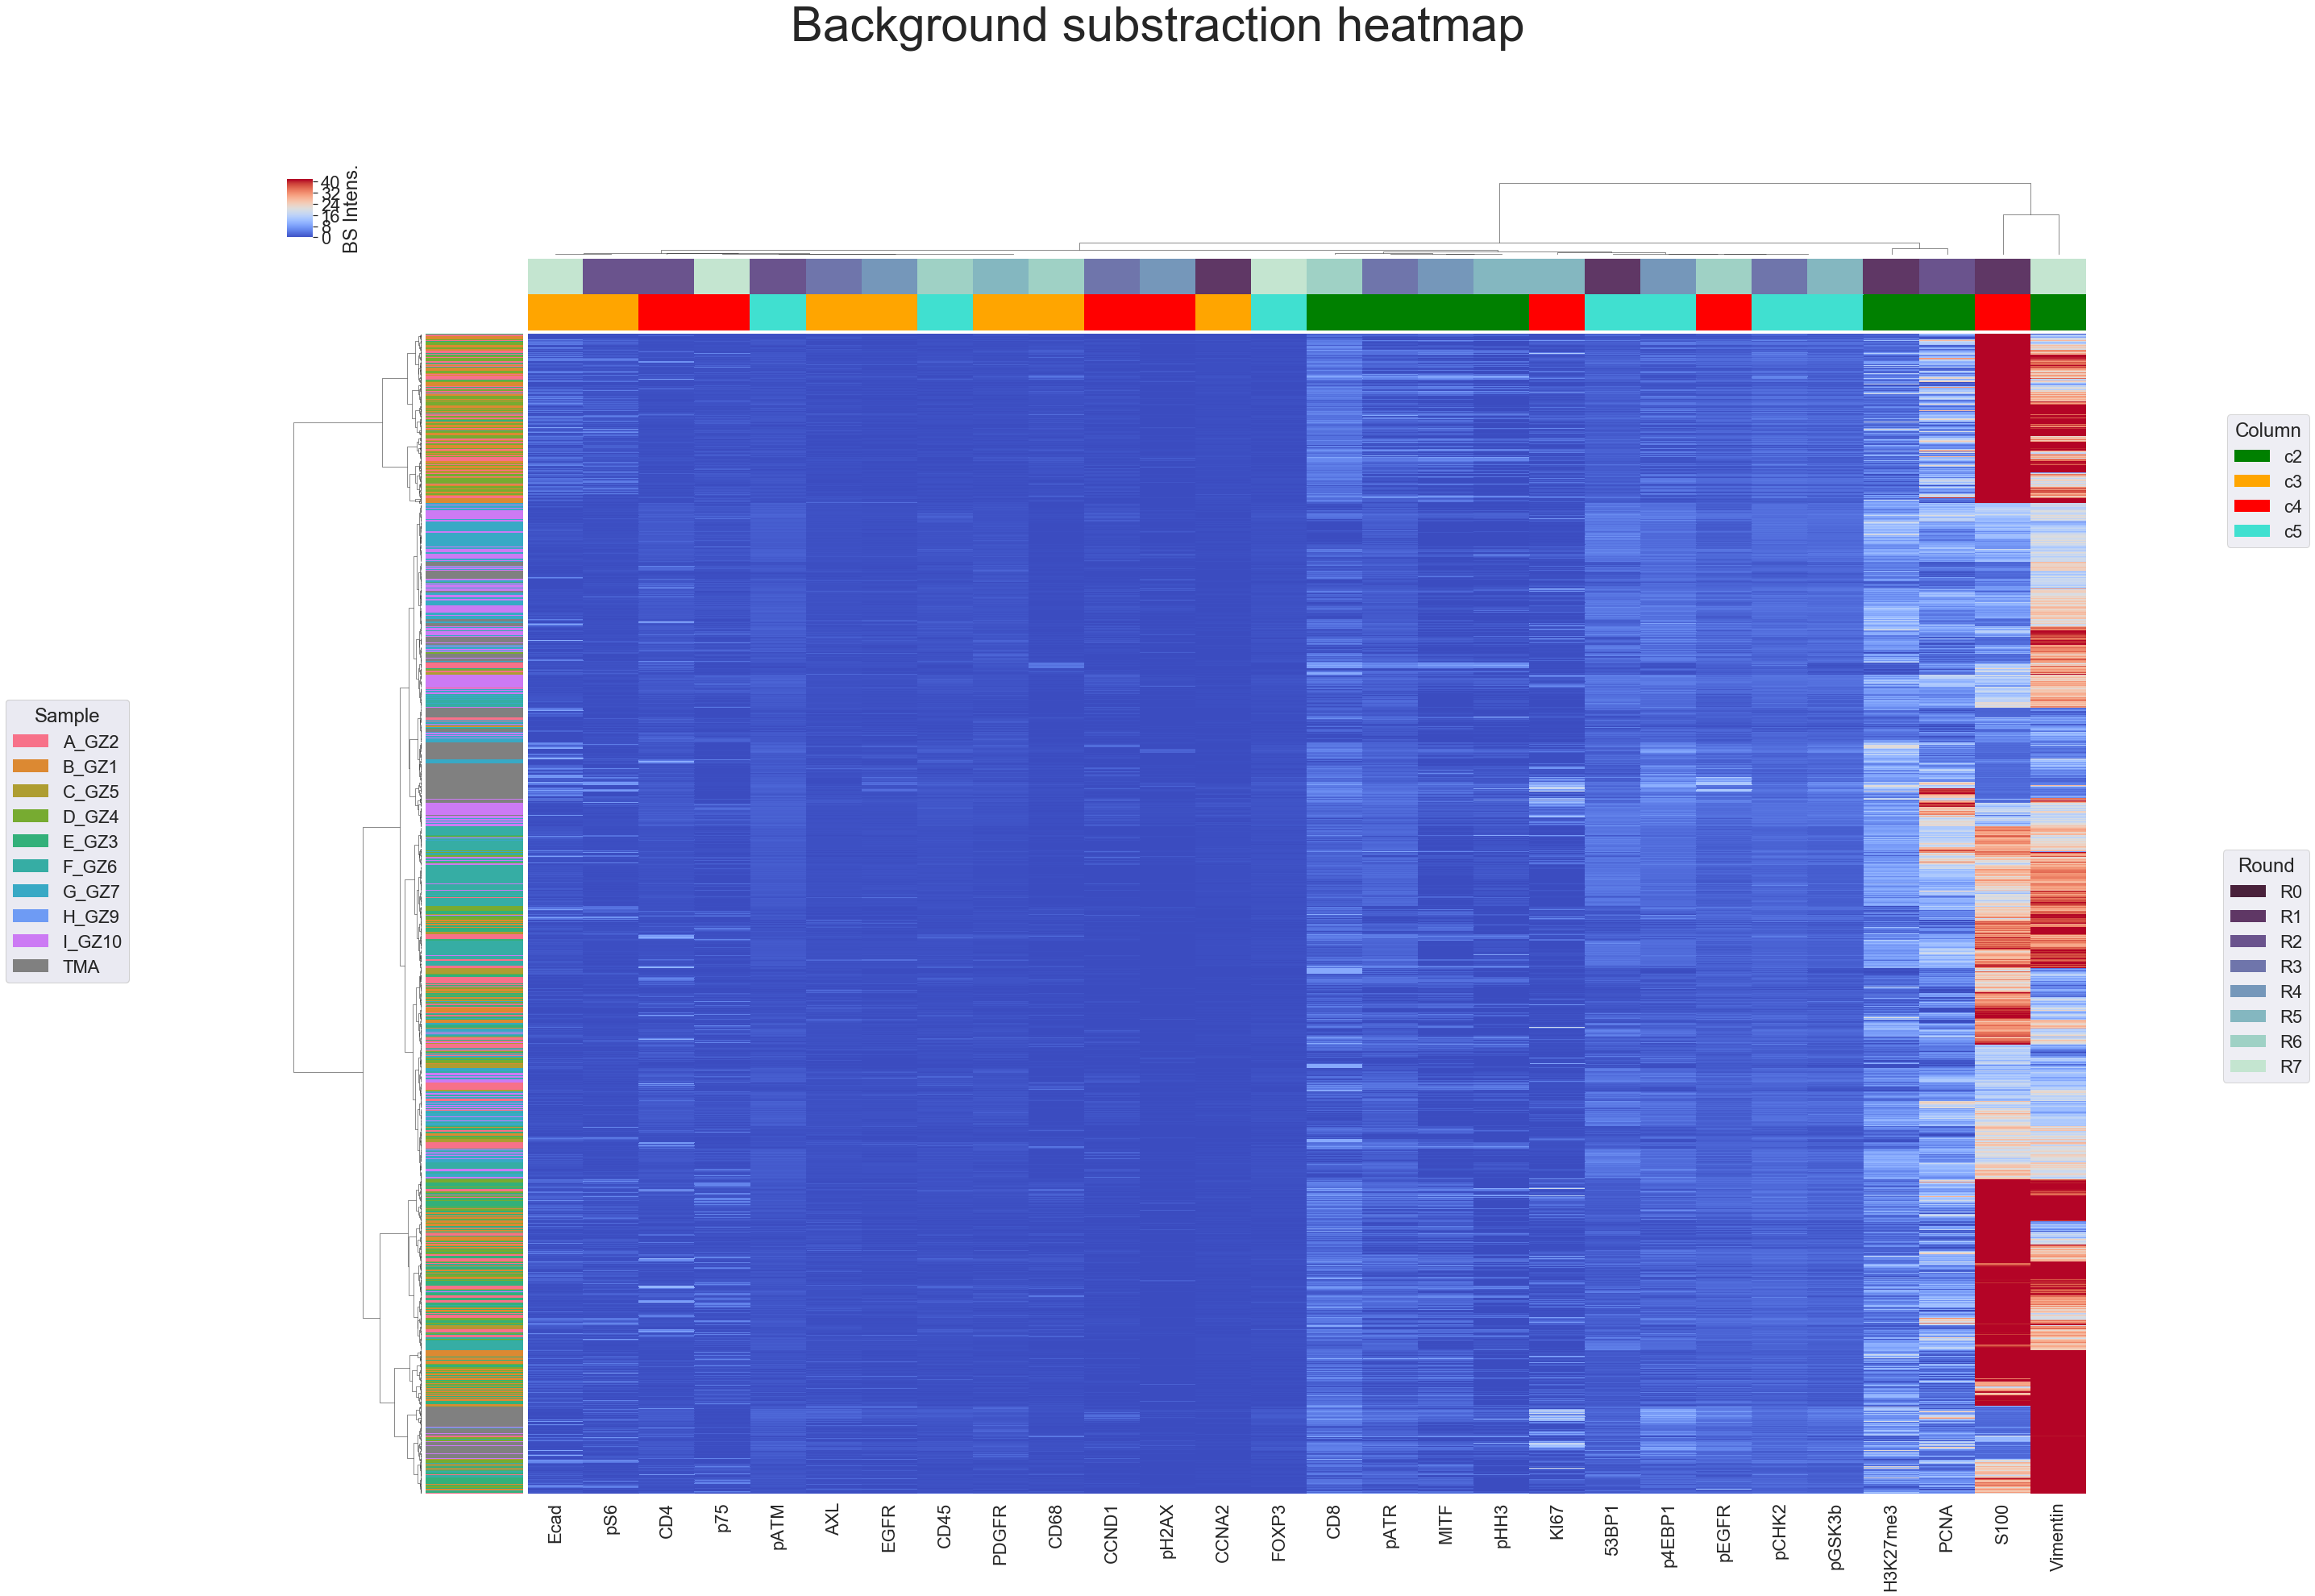

In [71]:
heatmap_function(data = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)],
    title = "Background substraction heatmap",
               # define method, metric, and color map
          method = 'ward', metric = 'euclidean',cmap = 'coolwarm',
               # colorbar (legend coloring of main plot) 
               cbar_kws = {'label':'BS Intens.'},
               # xticklabels - want to have the nicknames instead of full names
    xticklabels = [full_to_short_names[name] for name in 
                     heatmap_data.loc[:,
                                 ~heatmap_data.columns.isin(not_intensities)].columns.values],
                 save_loc = output_images_dir,
                 row_cluster = True, col_cluster = True,
                    annotations = annotations
          )

   #### XY plot - one per sample, colored by cell type

Use `for_filtering_app` if this times out.

In [72]:
for_app_data.columns.values

array(['53BP1_Cell_Intensity_Average', 'AF488_Cell_Intensity_Average',
       'AF555_Cell_Intensity_Average', 'AF647_Cell_Intensity_Average',
       'AF750_Cell_Intensity_Average', 'AXL_Cell_Intensity_Average',
       'CCNA2_Cell_Intensity_Average', 'CCND1_Cell_Intensity_Average',
       'CD45_Cell_Intensity_Average', 'CD4_Cell_Intensity_Average',
       'CD68_Cell_Intensity_Average', 'CD8_Cell_Intensity_Average',
       'Cell_Size', 'EGFR_Cell_Intensity_Average',
       'Ecad_Cell_Intensity_Average', 'FOXP3_Cell_Intensity_Average',
       'H3K27me3_Cell_Intensity_Average', 'KI67_Cell_Intensity_Average',
       'MITF_Cell_Intensity_Average', 'Nuc_X', 'Nuc_X_Inv', 'Nuc_Y',
       'Nuc_Y_Inv', 'Nucleus_Roundness', 'Nucleus_Size',
       'PCNA_Cell_Intensity_Average', 'PDGFR_Cell_Intensity_Average',
       'ROI_index', 'S100_Cell_Intensity_Average', 'Sample_ID',
       'Vimentin_Cell_Intensity_Average', 'p4EBP1_Cell_Intensity_Average',
       'p75_Cell_Intensity_Average', 'pATM_Cell_Inten

Doing just a subset set of cells due to lack of power in laptop to handle so many cells!

In [73]:
subset_row_count = 10000

In [74]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_subset = maintain_value_counts(df, 'Sample_ID',subset_row_count)
counts_for_subset

,current_row_count,prop,desired_row_count
A_GZ2,66137,0.091217,912
B_GZ1,1443,0.001990,20
C_GZ5,185,0.000255,3
D_GZ4,47135,0.065009,650
E_GZ3,5502,0.007588,76
F_GZ6,54962,0.075804,758
G_GZ7,425692,0.587117,5871
I_GZ10,32079,0.044244,442
TMA,91920,0.126777,1268


In [75]:
# Create new df to hold our heatmap data
df_subset = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_subset.loc[counts_for_subset.index == sample,'current_row_count'].values[0]
    size = counts_for_subset.loc[counts_for_subset.index == sample,'desired_row_count'].values[0]
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    df_subset = df_subset.append(df_sample.iloc[random_rows,:])
    
#for_app_data = for_app_data.loc[:,~for_app_data.columns.isin(not_intensities)]

In [76]:
for sample in ls_samples:
    location_colors = df_subset.loc[df_subset['Sample_ID'] == sample,['Nuc_X','Nuc_Y_Inv','cell_type']]

    fig = go.Figure()
    title = sample + " Background Subtracted XY Map"

    for celltype in df_subset.loc[df_subset['Sample_ID'] == sample,'cell_type'].unique():
        fig.add_scatter(
            mode = 'markers',
            marker=dict(
                        size=2, opacity = 0.70, # size is dot size, higher opacity = less opaque
                        color='rgb' + str(celltype_color_dict[celltype])#,
                #line = dict(width = 2, color = 'gray') # line around each marker
                       ),
        x = location_colors.loc[location_colors['cell_type']==celltype,'Nuc_X'],
        y = location_colors.loc[location_colors['cell_type']==celltype,'Nuc_Y_Inv'],
        name = celltype)


    fig.update_layout(title = title, plot_bgcolor = 'white',
                     legend= {'itemsizing': 'constant'}) # make the legend dots a bit bigger    
    fig.update_xaxes(title_text = 'Nuc_X', linecolor = 'black')
    fig.update_yaxes(title_text = 'Nuc_Y_Inv', linecolor = 'black')


    #plot(fig)
    fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")



### R Shiny - PCA

In [77]:
filename = "for_PCA.csv"
filename = os.path.join(output_data_dir, filename)
df_subset.to_csv(filename, index = False)

### Distributions

#### One per sample, one per marker

#### Distributions - one per channel

All samples are represented individually on each plot

In [78]:
metadata.loc[ (metadata['target_lower'].str.contains(r'^af\d{3}$')), ['Target','Channel']]

,Target,Channel
0,AF488,c2
1,AF555,c3
2,AF647,c4
3,AF750,c5


### Scatterplot - cell size vs nucleus size, color = nulceus roundess

Useful now that we have performed filtering. Note that real workflow will use the appropriate features that are lacking in this dataset.

In [79]:
df.columns[df.columns.isin(not_intensities)]

Index(['Cell_Size', 'Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv',
       'Nucleus_Roundness', 'Nucleus_Size', 'ROI_index', 'Sample_ID',
       'cell_type'],
      dtype='object')

In [81]:
title = "Nucleus size by cell size for post-filtering data"
x_label = "Nucleus Size"
y_label = "Cell Size" # cell size

fig = px.scatter(for_app_data, x="Cell_Size", y="Nucleus_Size",
                 color='Nucleus_Roundness')
                 
fig.update_layout(title_text=title, font=dict(size=18), 
        plot_bgcolor = 'white', showlegend = True )

# Adjust opacity of traces and size of marker
fig.update_traces(opacity=0.6, marker ={'size':5})
# Adjust x-axis parameters
fig.update_xaxes(title_text = x_label, showline=True, linewidth=2, linecolor='black', 
        tickfont=dict(size=18))
    # Adjust y-axis parameters
fig.update_yaxes(title_text = y_label, showline=True, linewidth=2, linecolor='black',
        tickfont=dict(size=18))
    
#plot(fig)
filename = title.replace(" ","_") + ".png"
filename = os.path.join(output_images_dir, filename)
fig.write_image(filename)

### Drop any other rows or columns we want to before saving data

In [ ]:
# Let's take a look
df.columns.values

For the sake of example, I will operate on a copy of df, called df_copy

In [ ]:
# You MUST do df.copy()
# 'df_copy = df' would essentially 
# give you two different names for the
# SAME dataframe, so operating on one
# would also operate on the other
df_copy = df.copy()

#### Operate on entire rows or columns

In [ ]:
# Drop columns
my_cols = []
df_copy = df_copy.drop(columns = my_cols)

In [ ]:
# Keep only specific columns (explained below)
my_cols = []
my_cols = df.columns.values
df_copy = df_copy.loc[:,my_cols]

#### Operate on rows and columns using filtering criteria

In [ ]:
# Keep only certain rows based off of criteria

# use df.loc[] to filter
# df.loc[rows,columns]
# df.loc[:,certain_cols] --> keep all rows ':', only certain cols
# df.loc[certain_rows,:] --> keep only certain row, all cols ':'

# Say we only want certain values for Sample_ID
print(df_copy.Sample_ID.unique())
keep = ['TMA1.1','TMA1.2','TMA1.3','TMA2.1','TMA2.2','TMA2.3']
df_copy = df_copy.loc[df_copy['Sample_ID'].isin(keep),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Filter on multiple criteria
# '&' or 'and'
# '|' or 'or'
# you MUST have parentheses around each logic expression!
df_copy = df_copy.loc[
    (df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        | (df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Remove rows based off of certain criteria
# note the negating tilde '~'!

df_copy = df_copy.loc[
    (~df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        & (~df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

### Save the data by Sample_ID

In [82]:
# Check for existence of output file first
for sample in ls_samples:
    filename = os.path.join(output_data_dir+ "/" + sample + "_" + step_suffix + ".csv")
    if os.path.exists(filename):
        print("File by name "+filename+" already exists.")

In [83]:
# Save output files
for sample in ls_samples:
    df_save = df.loc[df['Sample_ID'] == sample,:]
    filename = os.path.join(output_data_dir,   sample + "_" + step_suffix + ".csv")
    df_save.to_csv(filename, index = True)
